# Predicting Seattle Rain

Kaggle: [Dit it rain in Seattle?(1948-2017)](https://www.kaggle.com/rtatman/did-it-rain-in-seattle-19482017)

![](http://www.gaiahealthblog.com/wordpress1/wp-content/uploads/2015/12/Life-In-Seattle-2.jpg)


### Inspiration:
* Can we use this dataset to build a model of whether it will rain on a specific day given information on the previous days?
* Is there a correlation between the minimum and maximum tempetrure? Can we predict one given the other?
* Can we model changes in the amount of precipitation over time? Is there seasonlity?


## Imports

In [34]:
import pandas as pd

# Visualizations
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt
%matplotlib inline

create pandas dataframe from csv file

In [35]:
df = pd.read_csv('./seattleWeather_1948-2017.csv')
df.head()

,DATE,PRCP,TMAX,TMIN,RAIN
0,1948-01-01,0.47,51,42,True
1,1948-01-02,0.59,45,36,True
2,1948-01-03,0.42,45,35,True
3,1948-01-04,0.31,45,34,True
4,1948-01-05,0.17,45,32,True


#### Details about the Dataset
This data was collected at the Seattle-Tacoma International Airport. The dataset contains five columns:
* DATE = the date of the observation
* PRCP = the amount of precipitation, in inches
* TMAX = the maximum temperature for that day, in degrees Fahrenheit
* TMIN = the minimum temperature for that day, in degrees Fahrenheit
* RAIN = TRUE if rain was observed on that day, FALSE if it was not

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25551 entries, 0 to 25550
Data columns (total 5 columns):
DATE    25551 non-null object
PRCP    25548 non-null float64
TMAX    25551 non-null int64
TMIN    25551 non-null int64
RAIN    25548 non-null object
dtypes: float64(1), int64(2), object(2)
memory usage: 998.2+ KB


## Data Processing
This setp includes removing columns we do not need, check missing values, and indexing the date column for time series analysis and aggregation

#### Data Quality Check
next lets check the columns that contan `NaN` value

In [37]:
df.columns[df.isnull().any()].tolist()

['PRCP', 'RAIN']

In [38]:
df.isnull().sum()

DATE    0
PRCP    3
TMAX    0
TMIN    0
RAIN    3
dtype: int64

In [39]:
df = df.dropna()
df.isnull().sum()

DATE    0
PRCP    0
TMAX    0
TMIN    0
RAIN    0
dtype: int64

Since one of our objective is to build a model of whether it will rain on a specific day given information on the previous days, lets create a column to indicate whether it rained the prior day.

Next we will create use the `shift` method and create a new column called `rain_previous` to indiciate in a binary manner whether it previously rained the day before or not. Since the shift function essentially move the values from `RAIN` down one row, the first row will be `nan` and we cannot use any `nan` when were are performing machine learning, therefore, we willuse the `dropna()` function to drop that row. Also we need to reformat the `RAIN` and `rain_previous` from binary to integer. We perform this oberpation by multiply the column by 1. We also have the opption of converting the entire column of boolean values to a column of integers 1 or 0. 

In [40]:
df['rain_previous'] = df.RAIN.shift(1)
df = df.dropna()
df['rain_previous'] = df.rain_previous * 1
df['RAIN'] = df.RAIN * 1

In [41]:
df.RAIN = df.RAIN.astype(int)
df.rain_previous = df.rain_previous.astype(int)

## Exploritory Analysis

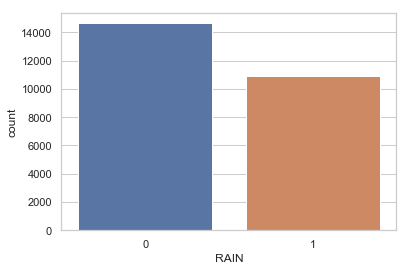

In [42]:
sns.countplot(df['RAIN'], label='Count')

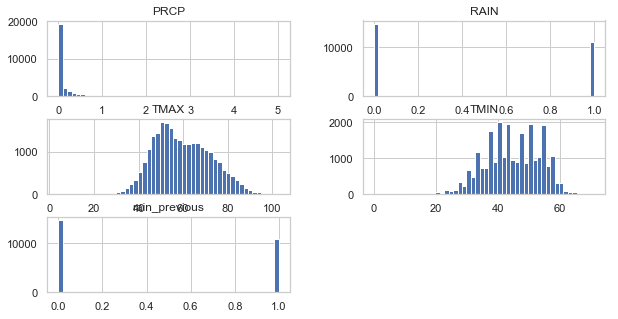

In [43]:
df.hist(bins=50, figsize=(10,5))
plt.show()

Observations: 
1. These scales seems to be on similar scales which is helpful for when we start feature engineering. 
2. For the exception of the `percepitation` historgram which is skewed right, the other histograms seems to be are somewhat normalized.

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


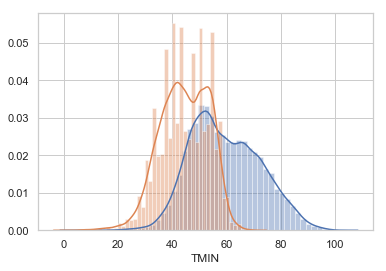

In [31]:
sns.distplot(df.TMAX)
sns.distplot(df.TMIN)

#### More Analysis on Temp Rain and Perception
Let's take a deeper look into the relationship between the `TMAX` and `TMIN`. However, let's first create a column to indicate days since the last rain _(potentially Rain in the past indicated whether it will rain today...given some temp)_ Or perhaps after raining 2 days, there is a pattern that 80% it does not rain Given some temp... will see

In [57]:
def cumulative_sum_limits(list_):
    """
    Cumulative Sum Function with limits to reset the summation to zero when incurring a 
    zero value.
    
    TODO: Think about doing a -1 for the first day not rain and then a reset on limit
    on the second cconsecutive day
    """
    limit = 0  # set set this limit to zero for the cumsum to reset
    
    for i in list_:
        limit = 0 if i == 0 else limit + i
        yield limit

In [63]:
df['cumsum_rain']  = list(cumulative_sum_limits(df.RAIN))
df.head()

,DATE,PRCP,TMAX,TMIN,RAIN,rain_previous,cumsum_rain
1,1948-01-02,0.59,45,36,1,1,1
2,1948-01-03,0.42,45,35,1,1,2
3,1948-01-04,0.31,45,34,1,1,3
4,1948-01-05,0.17,45,32,1,1,4
5,1948-01-06,0.44,48,39,1,1,5


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


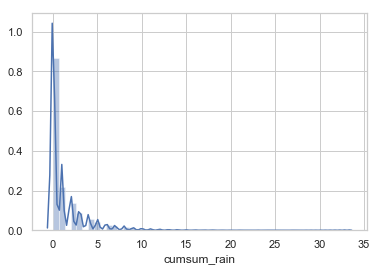

In [70]:
sns.distplot(df.cumsum_rain)

## Modeling: Predict whether it will rain on a specific day given the information from a previous day

In [11]:
df = df.drop('DATE', axis=1)

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.loc[:,df.columns != "RAIN"], df['RAIN'], stratify=df['RAIN'])

KNN

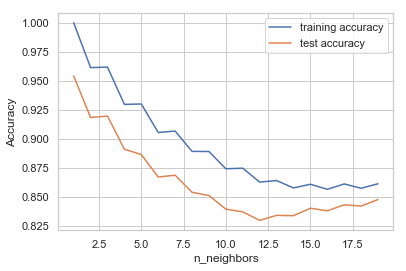

In [13]:
from sklearn.neighbors import KNeighborsClassifier

training_accuracy = []
test_accuracy = []
# try n_neighbors from 1 to 10
neighbors_settings = range(1, 20)

for n_neighbors in neighbors_settings:
    # build the model
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(knn.score(X_train, y_train))
    # record test set accuracy
    test_accuracy.append(knn.score(X_test, y_test))

plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()
#plt.savefig('knn_compare_model')

Regression

In [14]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression().fit(X_train, y_train)
print("Training set accuracy: {:.3f}".format(logreg.score(X_train, y_train)))
print("Test set accuracy: {:.3f}".format(logreg.score(X_test, y_test)))

Training set accuracy: 0.929
Test set accuracy: 0.930


In [176]:
logreg100 = LogisticRegression(C=100).fit(X_train, y_train)
print("Training set accuracy: {:.3f}".format(logreg100.score(X_train, y_train)))
print("Test set accuracy: {:.3f}".format(logreg100.score(X_test, y_test)))

Training set accuracy: 0.987
Test set accuracy: 0.988


## Naive Bayes

In [178]:
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

In [179]:
# instiate the classifier
gnb = GaussianNB()

gnb.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(gnb.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gnb.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 1.000


# Correlation: Is there a correlation between the minimum and maximum tempetrure? Can we predict one given the other?

Next as the title suggest we are looking to predict the tempeture given that there is a coorelation. 

In [180]:
df.head()

,PRCP,TMAX,TMIN,RAIN,rain_previous
1,0.59,45,36,1,1
2,0.42,45,35,1,1
3,0.31,45,34,1,1
4,0.17,45,32,1,1
5,0.44,48,39,1,1


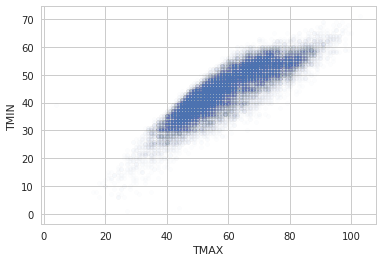

In [183]:
df.plot(kind="scatter", x="TMAX", y="TMIN", alpha=.01)

The correlation is indeed very strong between min and max tempreature. we can clearly see the upwared trend and the points are not too dispersed. In fact we actually had to use the `alpha` to show some of the density

In [184]:
corr_matrix = df.corr()
corr_matrix['rain_previous'].sort_values(ascending=False)

rain_previous    1.000000
RAIN             0.409772
PRCP             0.294138
TMIN            -0.197337
TMAX            -0.370021
Name: rain_previous, dtype: float64

plot the correlation matrix using a heatmap to explore the ocrrelation betwen features

Text(0.5,1,'Correlation between different features')

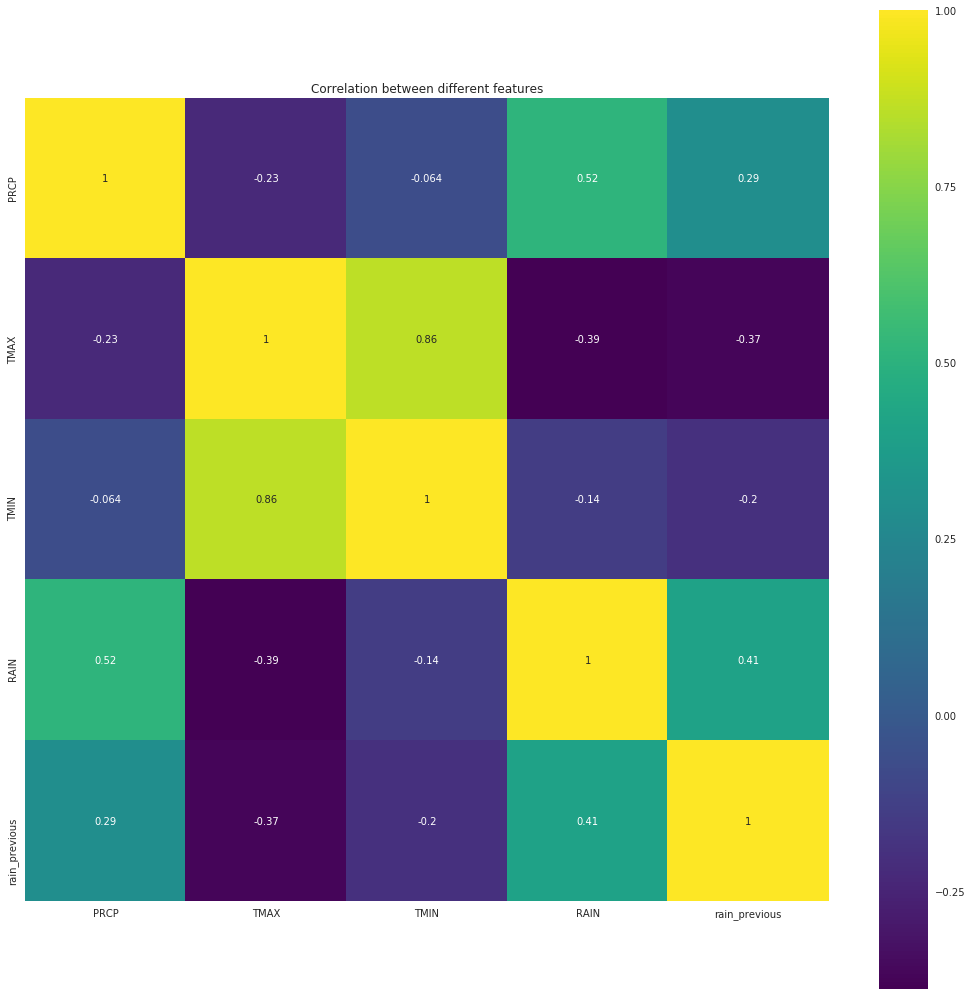

In [185]:
plt.figure(figsize=(18,18))
sns.heatmap(corr_matrix, vmax=1, square=True, annot=True, cmap='viridis')
plt.title('Correlation between different features')

The correlation is with the tempeture `TMAX` and `TMIN`
![Trina Bolfing](https://conversionsciences.com/wp-content/uploads/dont-let-correlation-steamroll-causation.png)

In [ ]:
NOT FINSIHED>>>> TBD